###### Package Imports

In [1]:
#  NumPy and Pandas imports
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from pandas.plotting import autocorrelation_plot

#  Reading time series
from pandas_datareader import data

import sklearn as sk
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Stationarity
import statsmodels.api as sm
import statsmodels.tsa as tsa

#  Time stamps
import datetime as datetime

#  Visualization (sns is a visualization library based on matplotlib)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

###### Extract Data

In [3]:
#  Start and End Date
start = datetime.date(2016, 4, 10)
end = datetime.date(2019, 4, 10)

#  Assign a database with historical stock quotes from Yahoo! Finance to CSCO
#  Cisco Systems, Inc.
CSCO = data.get_data_yahoo('CSCO', start, end)
CSCO_closing_prices = pd.DataFrame()
CSCO_closing_prices['Close'] = CSCO['Close']
CSCO_closing_prices['Date'] = CSCO_closing_prices.index
CSCO_closing_prices.set_index('Date')
#CSCO_closing_prices['Date'] = CSCO_closing_prices.index
CSCO_percent_change = CSCO_closing_prices['Close'].pct_change()

# Stationarity
--------
An important assumption in statistical estimation is that the sample does not
undergo any alteration while observations are being collected. This requires that the
internal structures don't change over time. Non-stationarity will result from the presence of 
trend and seasonality that affect the mean. This makes non-stationarity data hard to
reason about. 

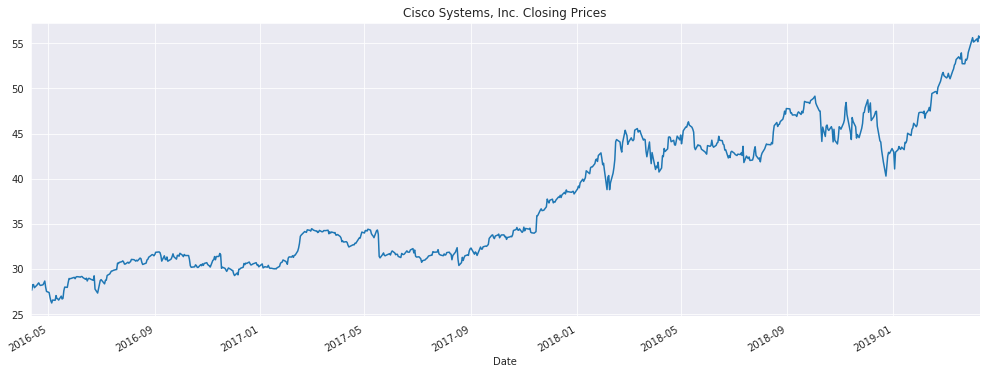

In [5]:
#  Financial market data is clearly non-stationarity.
CSCO_closing_prices['Close'].plot(title=
                                      "Cisco Systems, Inc. Closing Prices",
                                      figsize=(17, 6))

###### Stationarity Analysis:
The series is composed of signals and noise, which are unmodeled parts of the model.
 
    1. Differencing
    2. Transformation
    2. Decomposition



###### Stationarity Components:
Disaggregate a time series into components -- trend, seasonal, residual

* trend component
    - supposed to capture the slowly-moving overall level of the series
* seasonal component
    - captures patterns that repeat every season
* Residual component
    - residual is what is left


## Differencing
The basic idea is taking differences between successive occurrences of a time series
Δx<sub>t</sub> = x<sub>t</sub> - x<sub>t-1</sub> so that Δx<sub>t</sub> has a 
constant mean and variance (it can then be treated as stationary series)
## First-Order Differencing
The idea is to take differences between sequential observations so that the differences are 
a variation free from trend or seasonality. 

In [6]:
CSCO_closing_prices['First Order'] = CSCO['Close'] - CSCO['Close'].shift()

In [7]:
CSCO_closing_prices.head(3)

,Close,Date,First Order
Date,,,
2016-04-11,27.620001,2016-04-11,NaN
2016-04-12,27.639999,2016-04-12,0.019999
2016-04-13,28.230000,2016-04-13,0.590000


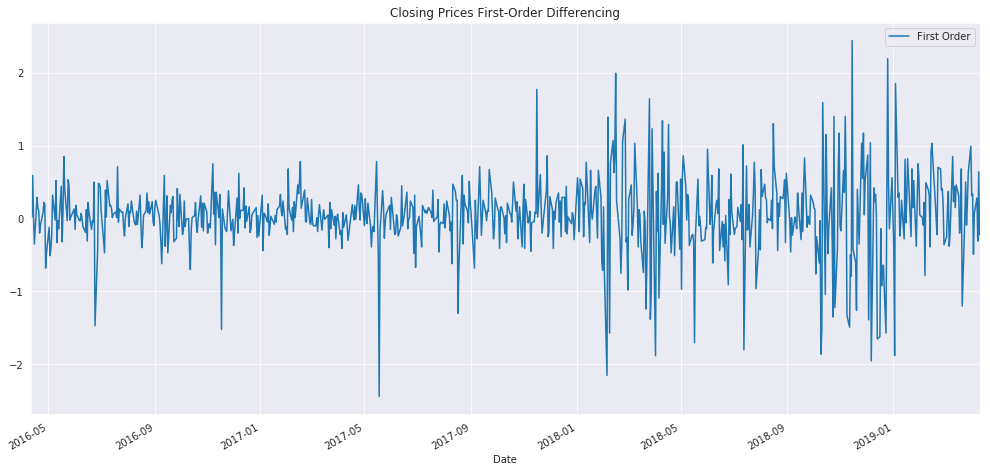

In [8]:
CSCO_closing_prices['First Order'].plot(legend=True,
                                        title="Closing Prices First-Order Differencing",
                                        figsize=(17, 8))

Data is no longer trending up, is now centered around zero. The variance is
a problem though. It increases over time, which is a sign the data is 
non-stationary and also exponentially increasing


## Transformation:
Apply a log transformation to penalizes higher values more than smaller values.

###### Note:
* Important property of Log-returns is that they're symmetrical around 0 with
respect to addition

                *This property makes it possible to talk about an average return
                (if a stock goes down 20% over a period of time, it has to gain 25% to be back
                where you started. For the log-return the numbers are .223 down over a period
                of time and .233 up to get back to where you started)

                *Arithmetic returns allow easier cross-sectional aggregation, log returns allow
                *for easier time aggregation (grouping rows)

In [9]:
#  (1) The lambda function takes 'Close' values and applies a log transformation
#  (2) The log transformation "flattens" data from exp curve to linear curve
CSCO_closing_prices['Log Transform'] = CSCO['Close'].apply(lambda x: np.log(x))

In [10]:
CSCO_closing_prices[['Log Transform', 'Close']].head()

,Log Transform,Close
Date,,
2016-04-11,3.318540,27.620001
2016-04-12,3.319264,27.639999
2016-04-13,3.340385,28.230000
2016-04-14,3.341093,28.250000
2016-04-15,3.328627,27.900000


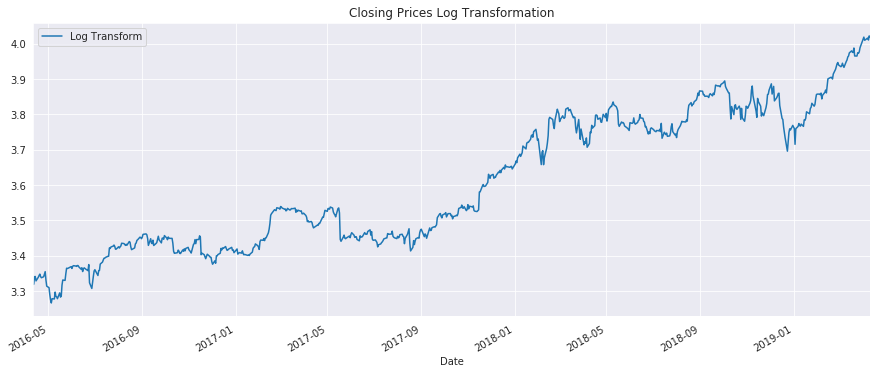

In [11]:
CSCO_closing_prices['Log Transform'].plot(legend=True,
                                        title="Closing Prices Log Transformation",
                                        figsize=(15, 6))

### Transformation Result on Rolling Variance 

In [12]:
#  calculate rolling variance of original closing prices
CSCO_closing_prices['Variance'] = CSCO['Adj Close'].rolling(window=30, 
                                               min_periods=None, 
                                               center=True).var()

In [13]:
#   calculate rolling variance of log transformed closing prices
CSCO_closing_prices['Log Variance'] = \
    CSCO_closing_prices['Log Transform'].rolling(30, center=True).var()

In [14]:
#  Display DataFrame
CSCO_closing_prices.dropna().head()

,Close,Date,First Order,Log Transform,Variance,Log Variance
Date,,,,,,
2016-05-02,27.370001,2016-05-02,-0.119999,3.309448,0.475166,0.000766
2016-05-03,26.860001,2016-05-03,-0.510000,3.290638,0.480474,0.000775
2016-05-04,26.440001,2016-05-04,-0.420000,3.274878,0.506318,0.000816
2016-05-05,26.209999,2016-05-05,-0.230001,3.266141,0.547216,0.000878
2016-05-06,26.530001,2016-05-06,0.320002,3.278276,0.584916,0.000936


Variance is more symmetrical in the transformed graph

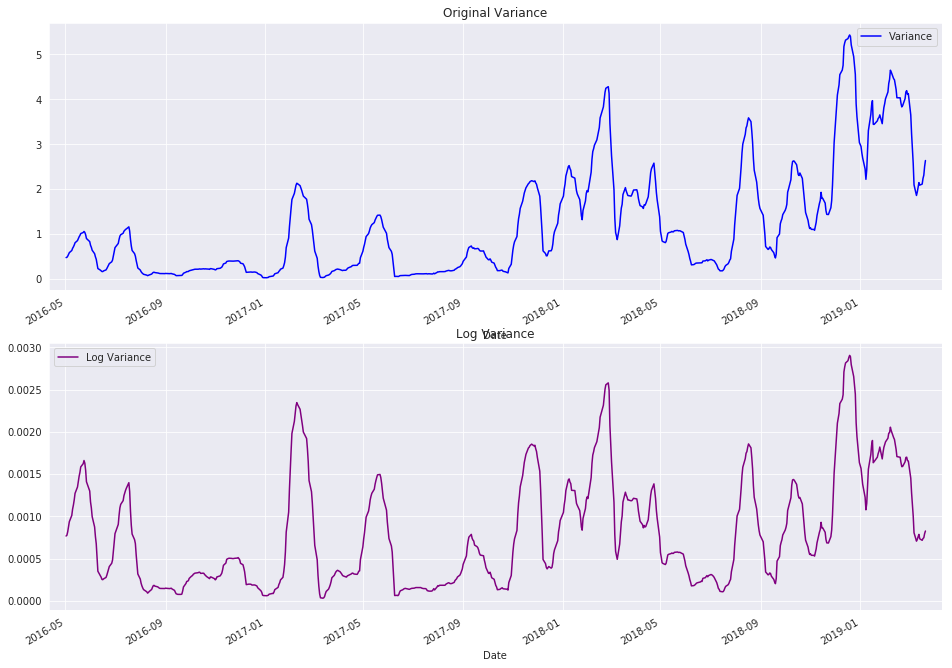

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))
#  Plot the rolling variance for original closing prices
CSCO_closing_prices['Variance'].plot(ax=ax[0],
                                     legend=True,
                                     title='Original Variance',
                                     color='blue')
#  Plot the rolling variance for log transformed closing prices
CSCO_closing_prices['Log Variance'].plot(ax=ax[1],
                                         legend=True,
                                         title='Log Variance',
                                         color='purple')

### Log Transform First-Order Difference

In [15]:
#  Get the Logged First Order Difference
CSCO_closing_prices['Logged First Order'] = CSCO_closing_prices['Log Transform'].diff()

In [16]:
#  Display data
CSCO_closing_prices.dropna().head(3)

,Close,Date,First Order,Log Transform,Variance,Log Variance,Logged First Order
Date,,,,,,,
2016-05-02,27.370001,2016-05-02,-0.119999,3.309448,0.475166,0.000766,-0.004375
2016-05-03,26.860001,2016-05-03,-0.510000,3.290638,0.480474,0.000775,-0.018809
2016-05-04,26.440001,2016-05-04,-0.420000,3.274878,0.506318,0.000816,-0.015760


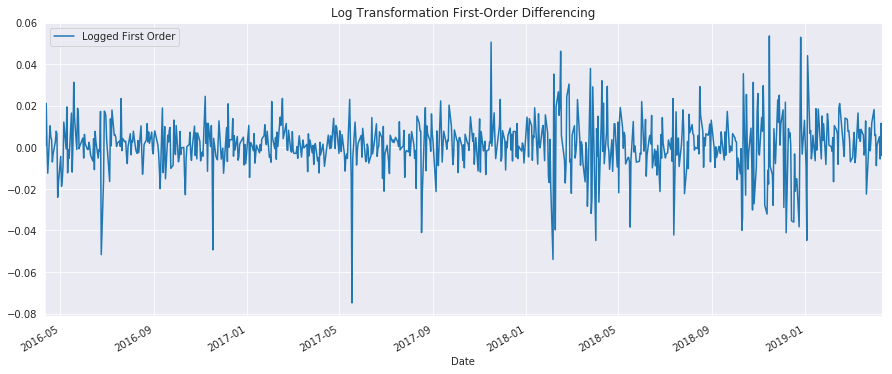

In [17]:
CSCO_closing_prices['Logged First Order'].plot(legend=True,
                                        title="Log Transformation First-Order Differencing",
                                        figsize=(15, 6))

## Lag Variables
First-Order Differences should be independent and identically distributed with a constant
mean and variance, which means no autocorrelation.

Check this with lag variables x<sub>t-1</sub>, x<sub>t-2</sub>, etc.. and compare
them to x<sub>t</sub>

###### Note:
Check the bivariate relationship for a mass around zero and the univariate distributions
as evenly distributed.

In [18]:
#  Create lag attributes for 5 days and 20 days
CSCO_closing_prices['Log Difference Lag 5'] = CSCO_closing_prices['Logged First Order'].shift(5)
CSCO_closing_prices['Log Difference Lag 20'] = CSCO_closing_prices['Logged First Order'].shift(20)

### Joint Distribution of Lag Variables and First-Order Difference

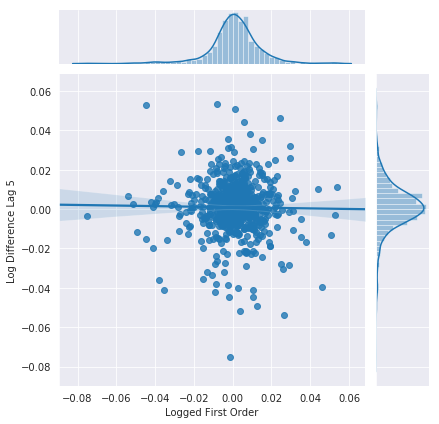

In [19]:
#  Check distribution in scatter plot of original attribute vs lagged attribute
sns.jointplot('Logged First Order', 'Log Difference Lag 5', CSCO_closing_prices, kind='reg', height=6)

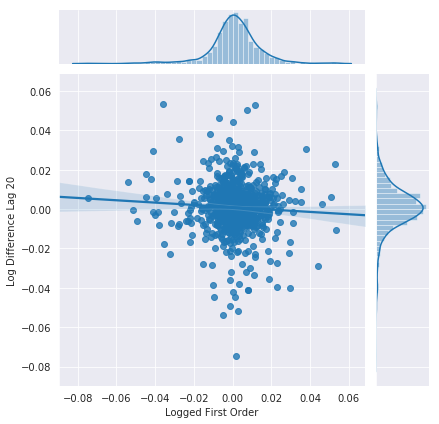

In [20]:
sns.jointplot('Logged First Order', 'Log Difference Lag 20', CSCO_closing_prices, kind='reg', height=6)

### Autocorrelation Function Verification

In [26]:
#  (1) ACF verifies if First-Order Differencing Standardized Time Series
#  (2) ACF computes correlation between variable & itself at each lag step till 40
log_acf = sm.tsa.acf(CSCO_closing_prices['Logged First Order'].dropna())


### Plotting Autocorrelation Function: 
Plotting ACF shows the correlation between a value at time t
and any time prior to t (up to 40 days behind). This time series model
is also known as a **Random Walk**

##### Note:
"A random walk is different than a list of rand numbers since the next value
in the sequence is a modification of the previous value in the sequence.
Generating the series forces a dependence from one time point to the next. This
dependence provides consistency that large jumps in an independent series doesnt.
The dependency gives the time series the name "random walk"

NameError: name 'log_acf' is not defined

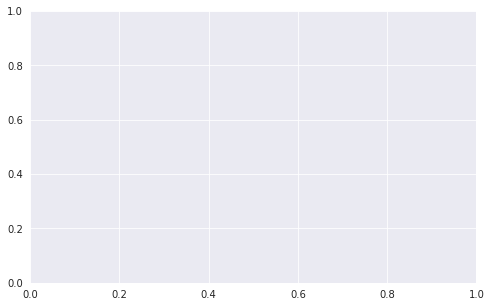

In [21]:
#  Plot ACF with Statsmodels package
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(log_acf, marker='.')

Plotting with pandas **autocorrelation_plot()** also visualizes the randomness
of a function. The horizontal dashed lines correspond to the 99% confidence band.
If a time series is random, then none of the autocorrelations will be significantly 
non-zero. As we can see here, the log transformation standardizes the dataset.

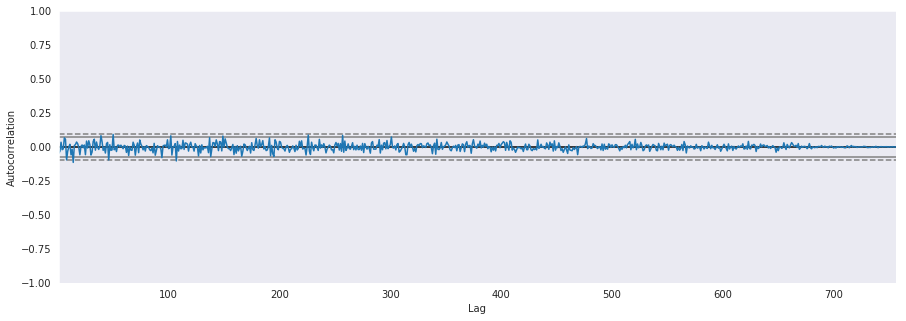

In [22]:
#  Plot Autocorrelation Function with pandas "autocorrelation_plot()" function
plt.figure(figsize=(15, 5))
autocorrelation_plot(CSCO_closing_prices['Logged First Order'].dropna())

## Decompose

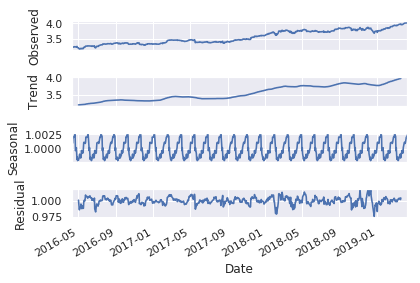

In [195]:
#  stats model function decomposes time series into trend, 
#  seasonality, and residual components.
decompose_data = sm.tsa.seasonal_decompose(CSCO_closing_prices['Log Transform'], 
                                           model="multiplicative", 
                                           freq=30)
figures = decompose_data.plot()
plt.rcParams['figure.figsize'] = [10.0, 12.0]
##  Trend is going up, seasonality is following a regular pattern

## Smoothing
--------
1. Given name because they "smoothen" out bumps in dataset.

2. The smoothing methods are based on an assumption that time series data is locally stationary
with small variations in the mean. Therefore, we can use the mean at time *t* to predict 
*t+1*, where the time delta is small enough to keep the signal stationary.  
### Moving Averages:
##### Note:
* **Moving averages** (**MA**) at time index *t* estimate the average trend cycle of component F<sub>t</sub>,
it is calculated by taking the average over the time period of t ± *k* where *k* is the range of the MA.

* Taking moving averages has an effect of smoothing the original time series by eliminating random noise.


In [25]:
#  The larger the window, the longer the new time series takes to react to changes in price
CSCO_closing_prices['MA for 10 days'] = CSCO_closing_prices['Close'].rolling(10).mean()
CSCO_closing_prices['MA for 20 days'] = CSCO_closing_prices['Close'].rolling(20).mean()
CSCO_closing_prices['MA for 50 days'] = CSCO_closing_prices['Close'].rolling(50).mean()

In [26]:
CSCO_closing_prices[['MA for 10 days', 'MA for 20 days', 'MA for 50 days']].dropna().head(2)

,MA for 10 days,MA for 20 days,MA for 50 days
Date,,,
2016-06-20,28.945,28.8930,28.047
2016-06-21,28.915,28.9345,28.070


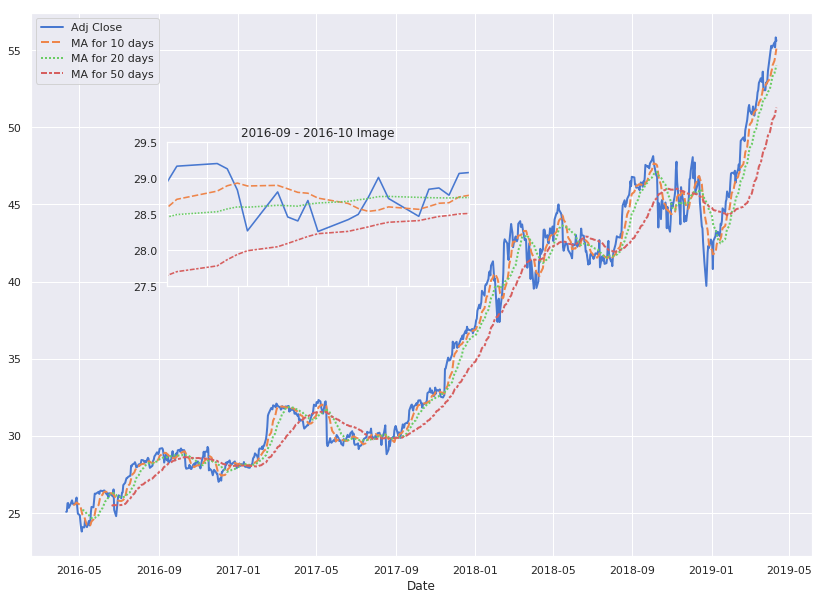

In [193]:
#  Plot Moving Averages                                                               
sns.set(rc={"lines.linewidth": 2.0})
figsize_1 = (14, 10)
figure_1, ax_1 = plt.subplots(figsize=figsize_1)
palette = sns.color_palette('muted', n_colors=4)
sns.lineplot(data=CSCO_closing_prices[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']],
             legend='full',
             palette=palette,
             hue=['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days'],
             ax=ax_1)

ax2 = plt.axes([0.26, 0.5, .3, .2])
plt.tick_params(
    axis='x',
    labelbottom=False
)
sns.set(rc={"lines.linewidth": 1.6})
sns.lineplot(data=CSCO_closing_prices[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']],
             palette=palette,
             legend=False,
            ax=ax2)
ax2.set_title('2016-09 - 2016-10 Image')
ax2.set_xlim(left='2016-09', right='2016-10')
ax2.set_ybound(27.5, 29.5)

### Expanding Mean 
In general, a fixed rolling window (Moving Average) time series is better than the expanding window time series. 

In [33]:
#  (1) Expanding Window Mean is a variant of Moving Window Mean
#  (2) .expanding() method repeatedly calculates mean, every iteration starts with 1st 
#       observation and inc window size by 1. 
CSCO_closing_prices['Expanding Mean'] = CSCO_closing_prices['Close'].expanding(center=True).mean()
test = CSCO_closing_prices[['Close', 'MA for 10 days', 'MA for 50 days', 'MA for 20 days']]


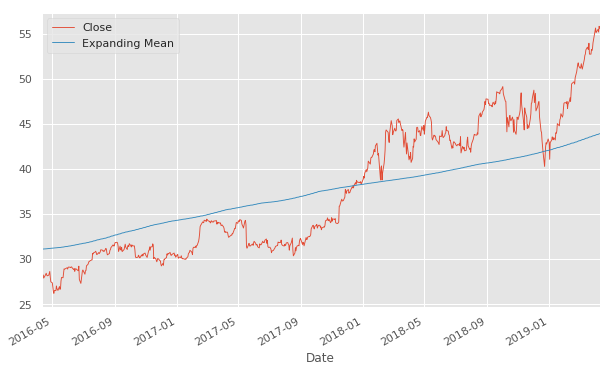

In [34]:
CSCO_closing_prices[['Close', 'Expanding Mean']].plot(subplots=False,
                                                          legend=True,
                                                          figsize=(10, 6))

## Exponential Smoothing
-------
##### Notes:

1. The major limitation of moving average-based models is that they treat all *n* samples 
used in smoothing equally and ignore the observation recency effect, which is giving higher
weights to recent observations. 

2. This is solved with exponential smoothing. The speed at which older responses are dampened
(smoothed) is a function of the alpha **α** value.

3. The higher alpha α, the closer the exponential smoothing line is to the original line. This means
larger values of α reduce the evel of smoothing.    

In [36]:
CSCO_closing_prices['ES α = .1'] = CSCO_closing_prices['Close'].ewm(alpha=0.1).mean()
CSCO_closing_prices['ES α = .3'] = CSCO_closing_prices['Close'].ewm(alpha=0.3).mean()
CSCO_closing_prices['ES α = .5'] = CSCO_closing_prices['Close'].ewm(alpha=0.5).mean()
CSCO_closing_prices['ES α = .7'] = CSCO_closing_prices['Close'].ewm(alpha=0.7).mean()
CSCO_closing_prices['ES α = .9'] = CSCO_closing_prices['Close'].ewm(alpha=0.9).mean()
CSCO_closing_prices['ES α = .2'] = CSCO_closing_prices['Close'].ewm(alpha=0.2).mean()
CSCO_closing_prices['ES α = .15'] = CSCO_closing_prices['Close'].ewm(alpha=0.15).mean()
CSCO_closing_prices['ES α = .25'] = CSCO_closing_prices['Close'].ewm(alpha=0.25).mean()
CSCO_closing_prices['ES α = .18'] = CSCO_closing_prices['Close'].ewm(alpha=0.18).mean()


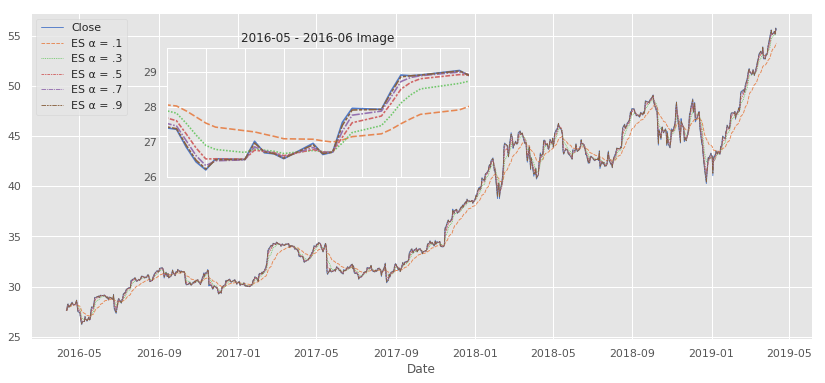

In [41]:
#  Specify matplotlob Figure and Axes
sns.set(rc={"lines.linewidth": 0.9})
plt.style.use('ggplot')
figsize_2 = (14, 6)
figure_2, ax_2 = plt.subplots(figsize=figsize_2)
palette = sns.color_palette('muted', n_colors=6, desat=.9)
ax.set_title('Visualize Exponential Smoothing Alphas (α)')

sns.lineplot(data=CSCO_closing_prices[['Close', 'ES α = .1', 'ES α = .3', 'ES α = .5', 'ES α = .7', 'ES α = .9']],
             legend='full',
             palette=palette,
             hue=['Close', 'ES α = .1', 'ES α = .3', 'ES α = .5', 'ES α = .7', 'ES α = .9'],
             ax=ax_2,
             err_style='bars'
             )

ax2 = plt.axes([0.26, 0.5, .3, .3])
plt.tick_params(
    axis='x',
    labelbottom=False
)
sns.set(rc={"lines.linewidth": 1.6})
sns.lineplot(data=CSCO_closing_prices[['Close', 'ES α = .1', 'ES α = .3', 'ES α = .5', 'ES α = .7', 'ES α = .9']],
             palette=palette,
             legend=False,
            ax=ax2)
ax2.set_title('2016-05 - 2016-06 Image')
ax2.set_xlim(left='2016-05', right='2016-06')
ax2.set_ybound(26, 29.7)

##### Narrowing Exponential Smoothing Factor with Mean Squared Error and Mean Absolute Error
It looks like the best exponential smoothing model is around ES α = .12 - .14. The alpha value is low
because the more observations in the dataset, the lower the optimal alpha value is. ES α = .1 is 
probably too low and will smooth the data too much.  

In [42]:
MSE = ['ES α = .1', 'ES α = .3', 'ES α = .5', 'ES α = .7', 'ES α = .9']
MSE[0] = mean_squared_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .1'])
MSE[1] = mean_squared_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .3'])
MSE[2] = mean_squared_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .5'])
MSE[3] = mean_squared_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .7'])
MSE[4] = mean_squared_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .9'])
MSE

[1.047910719375883,
 0.2408689641894263,
 0.08438934052857723,
 0.025499536687054476,
 0.0026597574585548803]

In [43]:
MAE = ['ES α = .1', 'ES α = .3', 'ES α = .5', 'ES α = .7', 'ES α = .9']
MAE[0] = mean_absolute_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .1'])
MAE[1] = mean_absolute_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .3'])
MAE[2] = mean_absolute_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .5'])
MAE[3] = mean_absolute_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .7'])
MAE[4] = mean_absolute_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .9'])
MAE

[0.7875281101387832,
 0.3469430456909806,
 0.19953705020860066,
 0.10844423680830403,
 0.034561655364855635]

#### Exponential Smoothing: Finding optimal Smoothing Factor (α)
A smoothing factor closer to 1.0 have less of smoothing effect and give greater weight to 
recent changes in the data (when α = 1, it becomes the observation). 
While values closer to 0.0 have a greater smoothing effect 
and are less responsive to recent changes. α is the "memory" of the estimator.

The smoothing factors tested for optimization are α = .120, .125, .130, .135, .140 
(Narrowed down from previous part)

In [44]:
CSCO_closing_prices['ES α = .120'] = CSCO_closing_prices['Close'].ewm(alpha=0.120).mean()
CSCO_closing_prices['ES α = .125'] = CSCO_closing_prices['Close'].ewm(alpha=0.125).mean()
CSCO_closing_prices['ES α = .130'] = CSCO_closing_prices['Close'].ewm(alpha=0.130).mean()
CSCO_closing_prices['ES α = .135'] = CSCO_closing_prices['Close'].ewm(alpha=0.135).mean()
CSCO_closing_prices['ES α = .140'] = CSCO_closing_prices['Close'].ewm(alpha=0.140).mean()
CSCO_closing_prices['ES α = .145'] = CSCO_closing_prices['Close'].ewm(alpha=0.145).mean()
CSCO_closing_prices['ES α = .80'] = CSCO_closing_prices['Close'].ewm(alpha=.80).mean()


Graphically visualize the smoothing factors

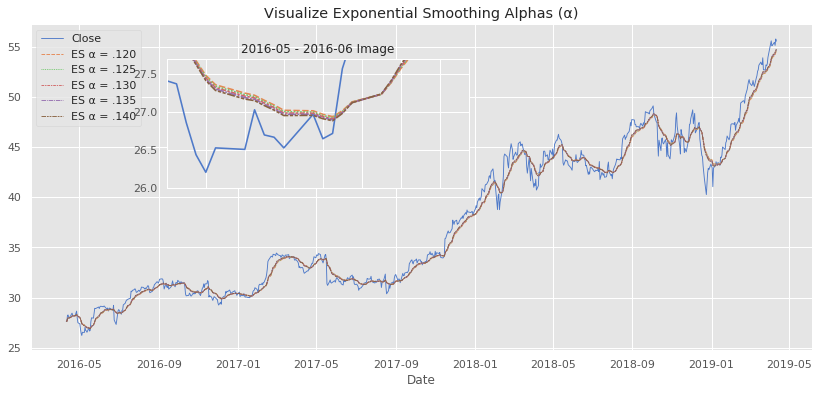

In [47]:
#  Specify matplotlob Figure and Axes
sns.set(rc={"lines.linewidth": 0.9})
plt.style.use('ggplot')
figsize_1 = (14, 6)
figure_1, ax_1 = plt.subplots(figsize=figsize_1)
palette = sns.color_palette('muted', n_colors=6, desat=.9)
ax_1.set_title('Visualize Exponential Smoothing Alphas (α)')

sns.lineplot(data=CSCO_closing_prices[['Close', 'ES α = .120', 'ES α = .125', 'ES α = .130', 
                                       'ES α = .135', 'ES α = .140',]],
             legend='full',
             palette=palette,
             hue=['Close', 'ES α = .120', 'ES α = .125', 'ES α = .130', 'ES α = .135', 'ES α = .140',],
             ax=ax_1,
             err_style='bars'
             )

ax2 = plt.axes([0.26, 0.5, .3, .3])
plt.tick_params(
    axis='x',
    labelbottom=False
)
sns.set(rc={"lines.linewidth": 1.6})
sns.lineplot(data=CSCO_closing_prices[['Close', 'ES α = .120', 'ES α = .125', 'ES α = .130', 
                                       'ES α = .135', 'ES α = .140',]],
             palette=palette,
             legend=False,
            ax=ax2)
ax2.set_title('2016-05 - 2016-06 Image')
ax2.set_xlim(left='2016-05', right='2016-06')
ax2.set_ybound(26, 27.7)


##### Checking Exponential Smoothing Model Accuracy with Mean Squared Error and Mean Absolute Error
We will use α = .130 for the predictive dataset.  

In [53]:
MSE_2 = ['ES α = .120', 'ES α = .125', 'ES α = .130', 'ES α = .135', 'ES α = .140', 'ES α = .145']
MSE_2[0] = mean_squared_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .120'])
MSE_2[1] = mean_squared_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .125'])
MSE_2[2] = mean_squared_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .130'])
MSE_2[3] = mean_squared_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .135'])
MSE_2[4] = mean_squared_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .140'])
MSE_2[5] = mean_squared_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .145'])
MSE_2

[0.846339505487301,
 0.8060967667822033,
 0.768958357642291,
 0.7345726035228347,
 0.7026393151321514,
 0.6729008124166116]

In [54]:
MAE_2 = ['ES α = .120', 'ES α = .125', 'ES α = .130', 'ES α = .135', 'ES α = .140', 'ES α = .145']
MAE_2[0] = mean_absolute_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .120'])
MAE_2[1] = mean_absolute_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .125'])
MAE_2[2] = mean_absolute_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .130'])
MAE_2[3] = mean_absolute_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .135'])
MAE_2[4] = mean_absolute_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .140'])
MAE_2[5] = mean_absolute_error(CSCO_closing_prices['Close'], CSCO_closing_prices['ES α = .145'])
MAE_2 


[0.7002504152085379,
 0.6813139361778721,
 0.6633454223935713,
 0.6462512623545763,
 0.6301574573713961,
 0.6147870276456435]

##### Exponential Weighted Moving Average (EWMA)
EWMA has less lag, which makes it more sensitive to recent prices and price changes. The more 
recent values favored means it will turn before regular MA. It's decision is partly based on
momentum. A simple MA will represent a truer average of prices for the entire time period.
We can see that EWMA, and MA still don't represent the price as well as a 
regular exponential smoothing model with α = .1

In [55]:
CSCO_closing_prices['EWMA for 10 days'] = CSCO_closing_prices['Close'].ewm(span=10).mean()


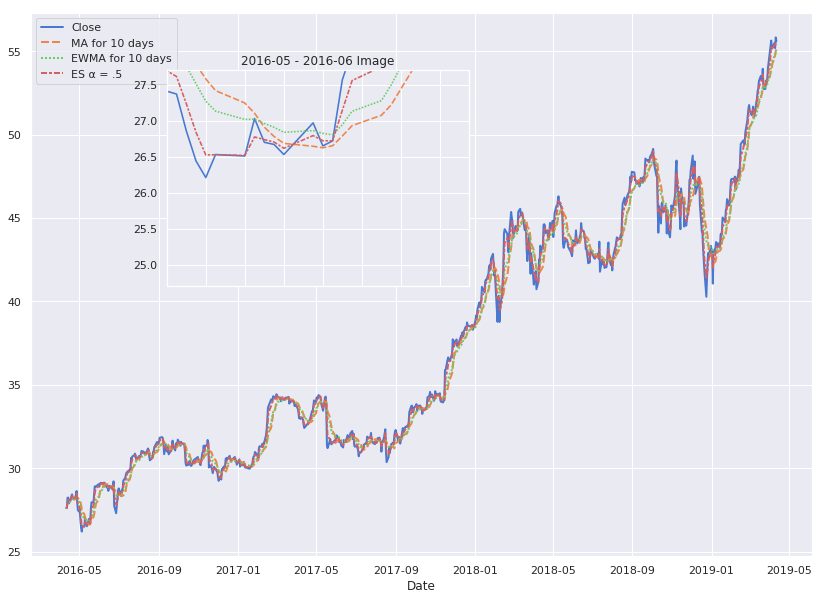

In [56]:
sns.set(rc={"lines.linewidth": 2.0})
figsize_3 = (14, 10)
figure_3, ax_3 = plt.subplots(figsize=figsize_3)
palette = sns.color_palette('muted', n_colors=4)
sns.lineplot(data=CSCO_closing_prices[['Close', 'MA for 10 days', 'EWMA for 10 days', 'ES α = .5']],
             legend='full',
             palette=palette,
             hue=['Close', 'MA for 10 days', 'EWMA for 10 days'],
             ax=ax_3)

ax2 = plt.axes([0.26, 0.5, .3, .3])
plt.tick_params(
    axis='x',
    labelbottom=False
)
sns.set(rc={"lines.linewidth": 1.6})
sns.lineplot(data=CSCO_closing_prices[['Close', 'MA for 10 days', 'EWMA for 10 days', 'ES α = .5']],
             palette=palette,
             legend=False,
            ax=ax2)
ax2.set_title('2016-05 - 2016-06 Image')
ax2.set_xlim(left='2016-05', right='2016-06')
ax2.set_ybound(24.7, 27.7)

             